In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

from pyq.similarity import CosineSimilarity, Exponential_Cityblock_Similarity
from pyq.tree import build_binary_tree_by_median_split
from pyq.utils.scatter_3d import scatter_3d
from pyq.tree.visualization import visualize_tree

from diffusion_map import DiffusionMap

#### Data Loading

In [2]:
file_path = '/Users/haiy/git/quests/questionnaire_matlab_legacy/examples/MMPI2_Depolarized.mat'
d = sp.io.loadmat(file_path)
data = d['matrix']
data_cols = d['points_dat']
data_rows = d['sensors_dat']
original_people_scores = d['original_people_scores']

#### Data preprocessing

In [3]:
vals,names=data_cols.squeeze().tolist()
names = [str(n[0]) for n in names.flatten().tolist()]
df_cols = pd.DataFrame(vals.T,columns=names)

df_rows = pd.DataFrame([[str(i[0])] for i in data_rows.squeeze().tolist()[0].flatten()],columns=['question'])

In [4]:
np.unique(data.flatten())

array([-1,  0,  1], dtype=int16)

#### data is presented as follows

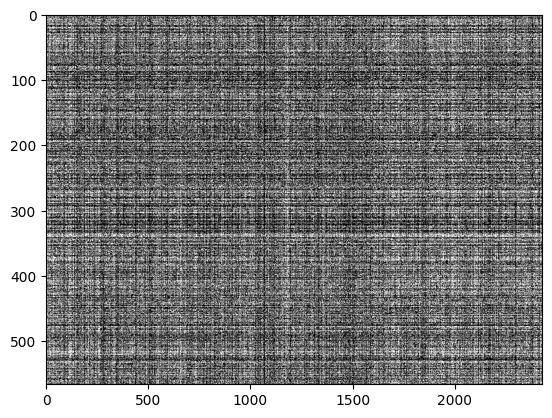

In [5]:
plt.imshow(data,cmap='gray',aspect='auto',vmin=0,vmax=1)
plt.show()

there is an obvious outlier that gets singled out at the level 1. 

-----------

#### Questionnaire Algorithm 

#### compute the dual geometry on the rows

In [6]:
# build initial tree on cosine similarity
col_sim = CosineSimilarity(0)(data.T)
col_tree = build_binary_tree_by_median_split(col_sim,min_size=2,max_depth=8)


# build the row tree based on the geometry on the columns
col_tree.compute_local_mean(data.T,'questionnaire')
col_tree.compute_inverse_cumsum('questionnaire')

row_emb = col_tree.compute_cumsum_expansion('questionnaire',l_end=9).T
row_sim = Exponential_Cityblock_Similarity()(row_emb)
row_tree = build_binary_tree_by_median_split(row_sim,min_size=1,max_depth=20)

/Users/haiy/git/quests/pyq/.venv/lib/python3.13/site-packages/diffusion_map/diffusion_embedding.py:124: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(S, k=self.n_dim + 1, which='LA')


#### A proper run of the questionnaire algorithm 

In [7]:
n_eigs = 8
iter_dual_geom = 5

In [8]:
row_iters = []
col_iters = []


# build initial col tree
col_sim = CosineSimilarity(0)(data.T)
col_emb = DiffusionMap(col_sim,n_dim=n_eigs).transform(t=1)
col_tree = build_binary_tree_by_median_split(col_sim,min_size=2,max_depth=8)

col_iters.append((col_sim,col_emb,col_tree))

# begin dual geometry iterations 
for i in range(iter_dual_geom):
    
    # update the rows
    _,_,col_tree = col_iters[-1]
    
    # compute the EMD embedding of rows based on the col tree
    col_tree.compute_local_mean(data.T,'questionnaire')
    col_tree.compute_inverse_cumsum('questionnaire')
    row_emb = col_tree.compute_cumsum_expansion('questionnaire',l_end=4).T    
    row_sim = Exponential_Cityblock_Similarity()(row_emb)
    row_emb = DiffusionMap(row_sim,n_dim=n_eigs).transform(t=1)
    row_tree = build_binary_tree_by_median_split(row_sim,min_size=1,max_depth=8)
    row_iters.append((row_sim,row_emb,row_tree))
    
    # compute the EMD embedding of cols based on the row tree
    
    _,_,row_tree = row_iters[-1]
    row_tree.compute_local_mean(data,'questionnaire')
    row_tree.compute_inverse_cumsum('questionnaire')
    col_emb = row_tree.compute_cumsum_expansion('questionnaire',l_end=3).T
    col_sim = Exponential_Cityblock_Similarity()(col_emb)
    col_emb = DiffusionMap(col_sim,n_dim=n_eigs).transform(t=1)
    col_tree = build_binary_tree_by_median_split(col_sim,min_size=2,max_depth=8)
    col_iters.append((col_sim,col_emb,col_tree))

#### visualizations 

In [9]:
_, row_emb, row_tree = row_iters[-1]
scatter_3d(row_emb,labels=np.zeros(row_emb.shape[0]))

In [10]:
_, col_emb, col_tree = col_iters[-1]

In [11]:
scatter_3d(col_emb,labels=KMeans(n_clusters=8).fit_predict(col_emb))

#### make the plots for the row trees

In [12]:
visualize_tree(row_tree)

In [13]:
visualize_tree(col_tree)